In [97]:
import pandas as pd
import numpy as np
import networkx as nx
import peartree as pear
import partridge as ptg
import matplotlib.pyplot as plt

In [98]:
feed = pear.get_representative_feed("gtfs_subway/")

start = 1  
end = 24*60*60 -1 
base = pear.load_feed_as_graph(feed, start, end).to_undirected()


c:\Users\pacma\OneDrive\Desktop\school\Graph Learning\subway\.venv\Lib\site-packages\peartree\graph.py:197: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for node_id, dist_val in nearest_nodes.iteritems():
c:\Users\pacma\OneDrive\Desktop\school\Graph Learning\subway\.venv\Lib\site-packages\peartree\graph.py:197: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for node_id, dist_val in nearest_nodes.iteritems():
c:\Users\pacma\OneDrive\Desktop\school\Graph Learning\subway\.venv\Lib\site-packages\peartree\graph.py:197: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for node_id, dist_val in nearest_nodes.iteritems():
c:\Users\pacma\OneDrive\Desktop\school\Graph Learning\subway\.venv\Lib\site-packages\peartree\graph.py:197: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for 

In [99]:
G = base

In [100]:
stops=list(G.nodes())
connectors = list(G.edges)

In [101]:
stops = [stop[-3:] for stop in stops]
station_data = pd.read_csv("MTA_Subway_Stations.csv")
station_data = station_data[['GTFS Stop ID', 'Complex ID', 'Stop Name', 'Daytime Routes']]

rl = [str(r).split() for r in station_data['Daytime Routes']]
station_data['Daytime Routes'] = rl

In [102]:
# PostProcessing graph
dn = dict(G.nodes.items())
kl = list(dn.keys())
for k in kl:
	m = k[-3:]
	ls = station_data[station_data['GTFS Stop ID'] == m]
	G.nodes[k]['lines'] = ls.iat[0,3]
	G.nodes[k]['GTFS ID'] = ls.iat[0,0]
	G.nodes[k]['Station Name'] = ls.iat[0,2]
	G.nodes[k]['Complex ID'] = ls.iat[0,1]
	try: del G.nodes[k]['modes']
	except KeyError: continue
nx.relabel_nodes(G, lambda x: x[-3:], copy=False)
G.edges.data()
el = list(dict(G.edges.items()))
for e in el:
	try: del G.edges[e]['mode']
	except KeyError: continue

In [103]:
# remove Staten Island Railroad

stps = list(dict(G.nodes.items()).keys())
for stp in stps:
	if 'SIR' in G.nodes[stp]['lines']:
		G.remove_node(stp)


In [104]:
## Add routes to edges
edgelist = G.edges.keys()
for edge in edgelist:
	stop1 = edge[0]
	stop2 = edge[1]
	edge_lines = set(G.nodes[stop1]['lines']).intersection(G.nodes[stop2]['lines'])
	G.edges[edge]['lines'] = edge_lines


In [105]:
## transfers in complex
transfers = pd.read_csv('gtfs_subway/transfers.txt')
transfers['lines'] = 0
for i in range(len(transfers['from_stop_id'])):
	coming = transfers['from_stop_id'][i]
	going = transfers['to_stop_id'][i]

	try: 
		d = (G.nodes[coming]['lines'], G.nodes[going]['lines'])
		transfers['lines'][i] = d
	except Exception as e:
		print(e)
		print(coming, going, i)
	
transfers.drop("transfer_type", inplace=True, axis=1)

transfers = transfers[transfers['from_stop_id'] != transfers['to_stop_id']]
transfers.reset_index(inplace=True,drop=True)

C:\Users\pacma\AppData\Local\Temp\ipykernel_28828\1326249141.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transfers['lines'][i] = d


In [106]:
S = [s for s in nx.connected_components(G)]
## 5 disconnected components without complexes
## S[0] is the IRT
## S[1] is the 7 train, and possibly express?
## S[2] is the 42 street shuttle
## S[3] is the BMT/IND
## S[4] is the L train
import itertools
def iterator(L):
	a, b = itertools.tee(L)
	next(b, None)
	return list(zip(a,b))


In [107]:
complexes = pd.read_csv("MTA_Subway_Stations_and_Complexes_20250918.csv")
complexes = complexes[complexes['Number Of Stations In Complex'] > 1]
complexes = complexes[['Complex ID','Number Of Stations In Complex', 'GTFS Stop IDs']]
gtfs_ids = [ids.split("; ") for ids in complexes['GTFS Stop IDs']]
complex_pairs = [list(itertools.combinations(sts, 2)) for sts in gtfs_ids]
complexes['complex_transfers'] = complex_pairs
complexes = complexes.explode('complex_transfers', ignore_index=True).drop(['Number Of Stations In Complex','GTFS Stop IDs'], axis= 1)
transfer_edges = list(zip(transfers['from_stop_id'], transfers['to_stop_id']))
transfer_edge_set = set()
for k in transfer_edges:
	transfer_edge_set.add(tuple(sorted(k)))

##print(transfer_edge_set ^ set(complexes['complex_transfers']))


##('254', 'L26'), ('629', 'B08'), ('B08', 'R11')##

## Out of station transfers specified on the official map
## Walk Junius to Livonia
## Walk Lexington-59 NRW to Lexington-63 -- 300s
## walk Lexington-59 456 to Lexington-63 -- 300s
transfers['edges'] = [tuple(sorted(k)) for k in transfer_edges]
unique_transfers = transfers.sort_values('edges').iloc[::2,:]
unique_transfers.reset_index(drop=True,inplace=True)
unique_transfers.drop(['from_stop_id', 'to_stop_id'], axis=1, inplace=True)

In [108]:
for u, v, data in G.edges(data=True):
    try:
        data["time"] = data.pop("length")
    except: continue
G.edges.data()

MultiEdgeDataView([('101', '103', {'lines': {'1'}, 'time': 120.0}), ('103', '104', {'lines': {'1'}, 'time': 92.57142857142857}), ('104', '106', {'lines': {'1'}, 'time': 90.0}), ('106', '107', {'lines': {'1'}, 'time': 90.0}), ('107', '108', {'lines': {'1'}, 'time': 89.17050691244239}), ('108', '109', {'lines': {'1'}, 'time': 90.0}), ('109', '110', {'lines': {'1'}, 'time': 90.0}), ('110', '111', {'lines': {'1'}, 'time': 90.0}), ('111', '112', {'lines': {'1'}, 'time': 120.0}), ('112', '113', {'lines': {'1'}, 'time': 96.05504587155963}), ('113', '114', {'lines': {'1'}, 'time': 120.0}), ('114', '115', {'lines': {'1'}, 'time': 90.0}), ('115', '116', {'lines': {'1'}, 'time': 101.48648648648648}), ('116', '117', {'lines': {'1'}, 'time': 138.51351351351352}), ('117', '118', {'lines': {'1'}, 'time': 60.0}), ('118', '119', {'lines': {'1'}, 'time': 71.43497757847534}), ('119', '120', {'lines': {'1'}, 'time': 90.0}), ('120', '121', {'lines': {'1'}, 'time': 109.05579399141631}), ('120', '123', {'lin

In [109]:
fstop = [unique_transfers['edges'][k][0] for k in unique_transfers.index]
tstop = [unique_transfers['edges'][k][1] for k in unique_transfers.index]
ttime = unique_transfers['min_transfer_time']
weighted_edge_list = list(zip(fstop, tstop, ttime))
G.add_weighted_edges_from(weighted_edge_list, weight='time',lines=set(["Transfer"]))


In [111]:
C = [s for s in nx.connected_components(G)]
len(C)

##nx.relabel_nodes(G, lambda x: G.nodes[x]['Complex ID'], copy=False)

1

In [112]:
elist = list(G.edges.data())
edict = {}
for i in range(len(elist)):
	start =elist[i][0]
	stop = elist[i][1]
	data = elist[i][2]
	edict[(start, stop)] = data


In [113]:
node_data = pd.DataFrame.from_dict(dict(G.nodes.data()))
edge_list2 = list(G.edges.data(True))
edge_list_pairs = {}
for e in edge_list2:
	edge_list_pairs[(e[0], e[1])] = e[2]

edge_data = pd.DataFrame.from_dict(edge_list_pairs).T


In [114]:
## rename 6x and 7x (ignore skip stop)
seven_express = edge_data[['7' in k for k in edge_data['lines']]]
seven_express
## non express edges 
# 710-709
# 709-708
# 708-707
# 707-706
# 706-705
# 705-702

## express only
# 710-707
# 707-702

not7x = [('710', '709',0), ('709','708'),('708','707'),('707','706'),('706','705')]
only7x = [('710', '707'), ('707','702')]
for edge in seven_express.index:
	edgek = (edge[0], edge[1], 0)
	if edge not in not7x:
		G.edges[edgek]['lines'].add("7x")
	
for edge in only7x:
	edgek = (edge[0], edge[1], 0)
	try:
		G.edges[edgek]['lines'].remove('7')
	except KeyError: continue


In [115]:
six_express = edge_data[['6' in k for k in edge_data['lines']]]
six_express

## non express edges
# 619, 618, 617, 616, 615, 614, 613, 612, 611, 610, 609, 608
## express only
# 619, 613, 608

not6x = [tuple([str(c) for c in d]) for d in iterator(range(608, 620))]
only6x = [('619', '613'), ('613', '608')]
for edge in six_express.index:
	edgek = (edge[0], edge[1], 0)
	if edge not in not6x:
		G.edges[edgek]['lines'].add("6x")
	
for edge in only6x:
	edgek = (edge[0], edge[1], 0)
	try:
		G.edges[edgek]['lines'].remove('6')
	except KeyError: continue

In [ ]:
non_express_nodes_6 = [str(k) for k in [618, 617, 616, 615, 614, 612, 611, 610, 609]]
for n in G.nodes:
	if '6' in G.nodes[n]['lines']:
		if n not in non_express_nodes_6:
			if '6x' not in G.nodes[n]['lines']:
				G.nodes[n]['lines'].append('6x')


non_express_nodes_7 = [str(k) for k in [709, 708, 706, 705]]
for n in G.nodes:
	if '7' in G.nodes[n]['lines']:
		if n not in non_express_nodes_7:
			if '7x' not in G.nodes[n]['lines']:
				G.nodes[n]['lines'].append('7x')

In [126]:

for st in G.nodes:
	if type(G.nodes[st]['boarding_cost']) is float:
		board_cost = {}
		for line in G.nodes[st]['lines']:
			board_cost[line] = G.nodes[st]['boarding_cost']
		G.nodes[st]['boarding_cost'] = board_cost
	lineset = set(G.nodes[st]['lines'])
	G.nodes[st]['lines'] = lineset

In [128]:
G.nodes.data()

NodeDataView({'101': {'boarding_cost': {'1': 204.73459715639817}, 'y': 40.889248, 'x': -73.898583, 'lines': {'1'}, 'GTFS ID': '101', 'Station Name': 'Van Cortlandt Park-242 St', 'Complex ID': 293}, '103': {'boarding_cost': {'1': 197.94030742775658}, 'y': 40.884667, 'x': -73.90087, 'lines': {'1'}, 'GTFS ID': '103', 'Station Name': '238 St', 'Complex ID': 294}, '104': {'boarding_cost': {'1': 197.94030742775658}, 'y': 40.878856, 'x': -73.904834, 'lines': {'1'}, 'GTFS ID': '104', 'Station Name': '231 St', 'Complex ID': 295}, '106': {'boarding_cost': {'1': 197.4574428118217}, 'y': 40.874561, 'x': -73.909831, 'lines': {'1'}, 'GTFS ID': '106', 'Station Name': 'Marble Hill-225 St', 'Complex ID': 296}, '107': {'boarding_cost': {'1': 194.65328407891528}, 'y': 40.869444, 'x': -73.915279, 'lines': {'1'}, 'GTFS ID': '107', 'Station Name': '215 St', 'Complex ID': 297}, '108': {'boarding_cost': {'1': 194.65328407891528}, 'y': 40.864621, 'x': -73.918822, 'lines': {'1'}, 'GTFS ID': '108', 'Station Name

In [250]:
G_visual = G.copy()
pairs = itertools.combinations(G.nodes.data(), 2)
close_stops = []
for a,b in pairs:
	x1 = a[1]['x']
	y1 = a[1]['y']
	x2 = b[1]['x']
	y2 = b[1]['y']
	dist = np.sqrt((x2-x1)**2 + (y2-y1)**2)
	if dist == 0: 
		close_stops.append((a[0],b[0]))
	elif a[1]['Complex ID'] == b[1]['Complex ID'] and dist < 5e-4:
		close_stops.append((a[0],b[0]))

for stoppair in close_stops:
	print(stoppair)
	nx.contracted_edge(G_visual, stoppair, copy=False, self_loops=False)

('125', 'A24')
('127', '725')
('414', 'D11')
('639', 'Q01')
('710', 'G14')
('718', 'R09')
('A12', 'D13')
('A32', 'D20')
('A38', 'M22')
('D17', 'R17')


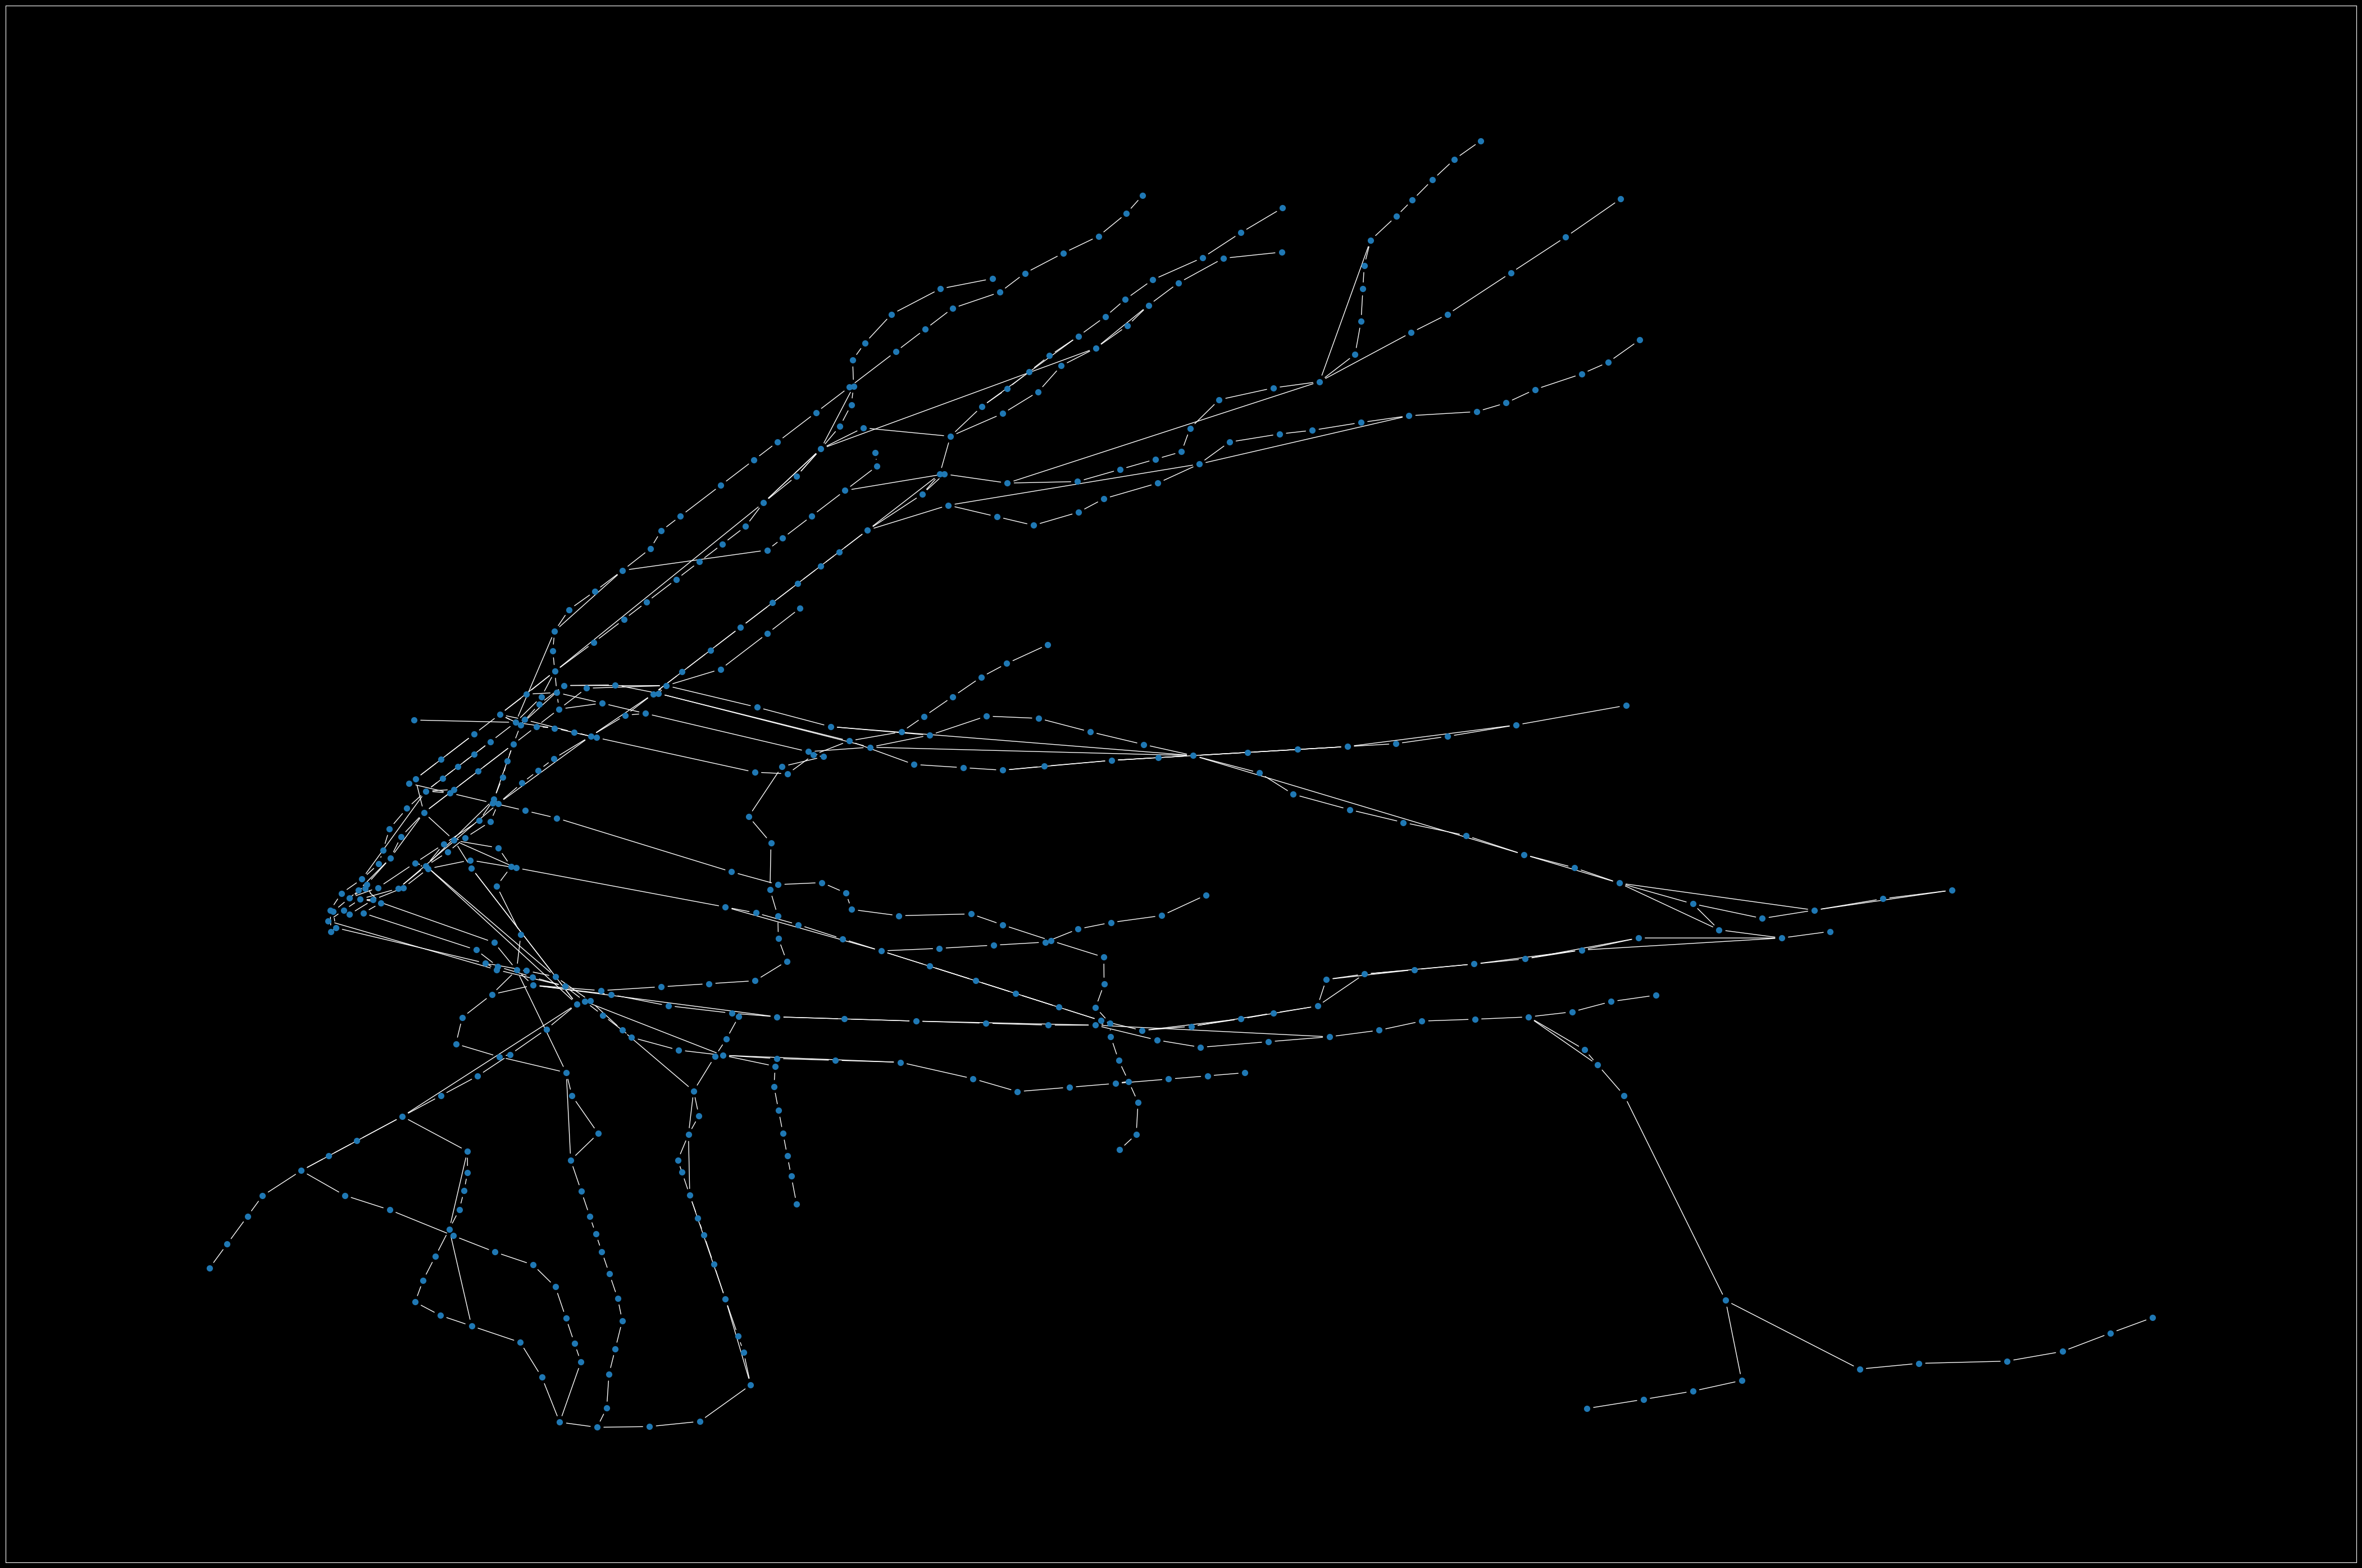

In [251]:

node_pos = dict(G_visual.nodes.data())
st_pos = pd.DataFrame.from_dict(node_pos).T
st_pos = st_pos[['x','y']].T.to_dict()
coords = [list(list(st_pos.values())[n].values()) for n in range(len(st_pos))]
xylist = np.transpose(coords)
xrange = [min(xylist[0]),max(xylist[0])]
yrange = [min(xylist[1]),max(xylist[1])]
xylist[0] += 74
xylist[1] -= 40
xylist[0]*=10
coords = np.transpose(xylist)
coords = [tuple(i) for i in coords]
plt.figure(1, figsize=(54,36))
pos = dict(zip(G_visual.nodes, coords))

nx.draw_networkx_nodes(G_visual,node_size=50, pos = pos, label=True)
nx.draw_networkx_edges(G_visual, width=1, edge_color='w', pos=pos, edge_vmin=0)
plt.show()


In [334]:
sorted(nx.degree(G_visual), key=lambda x: x[1], reverse=True)[:6]

[('127', 11), ('639', 10), ('710', 9), ('A12', 8), ('A38', 8), ('125', 7)]

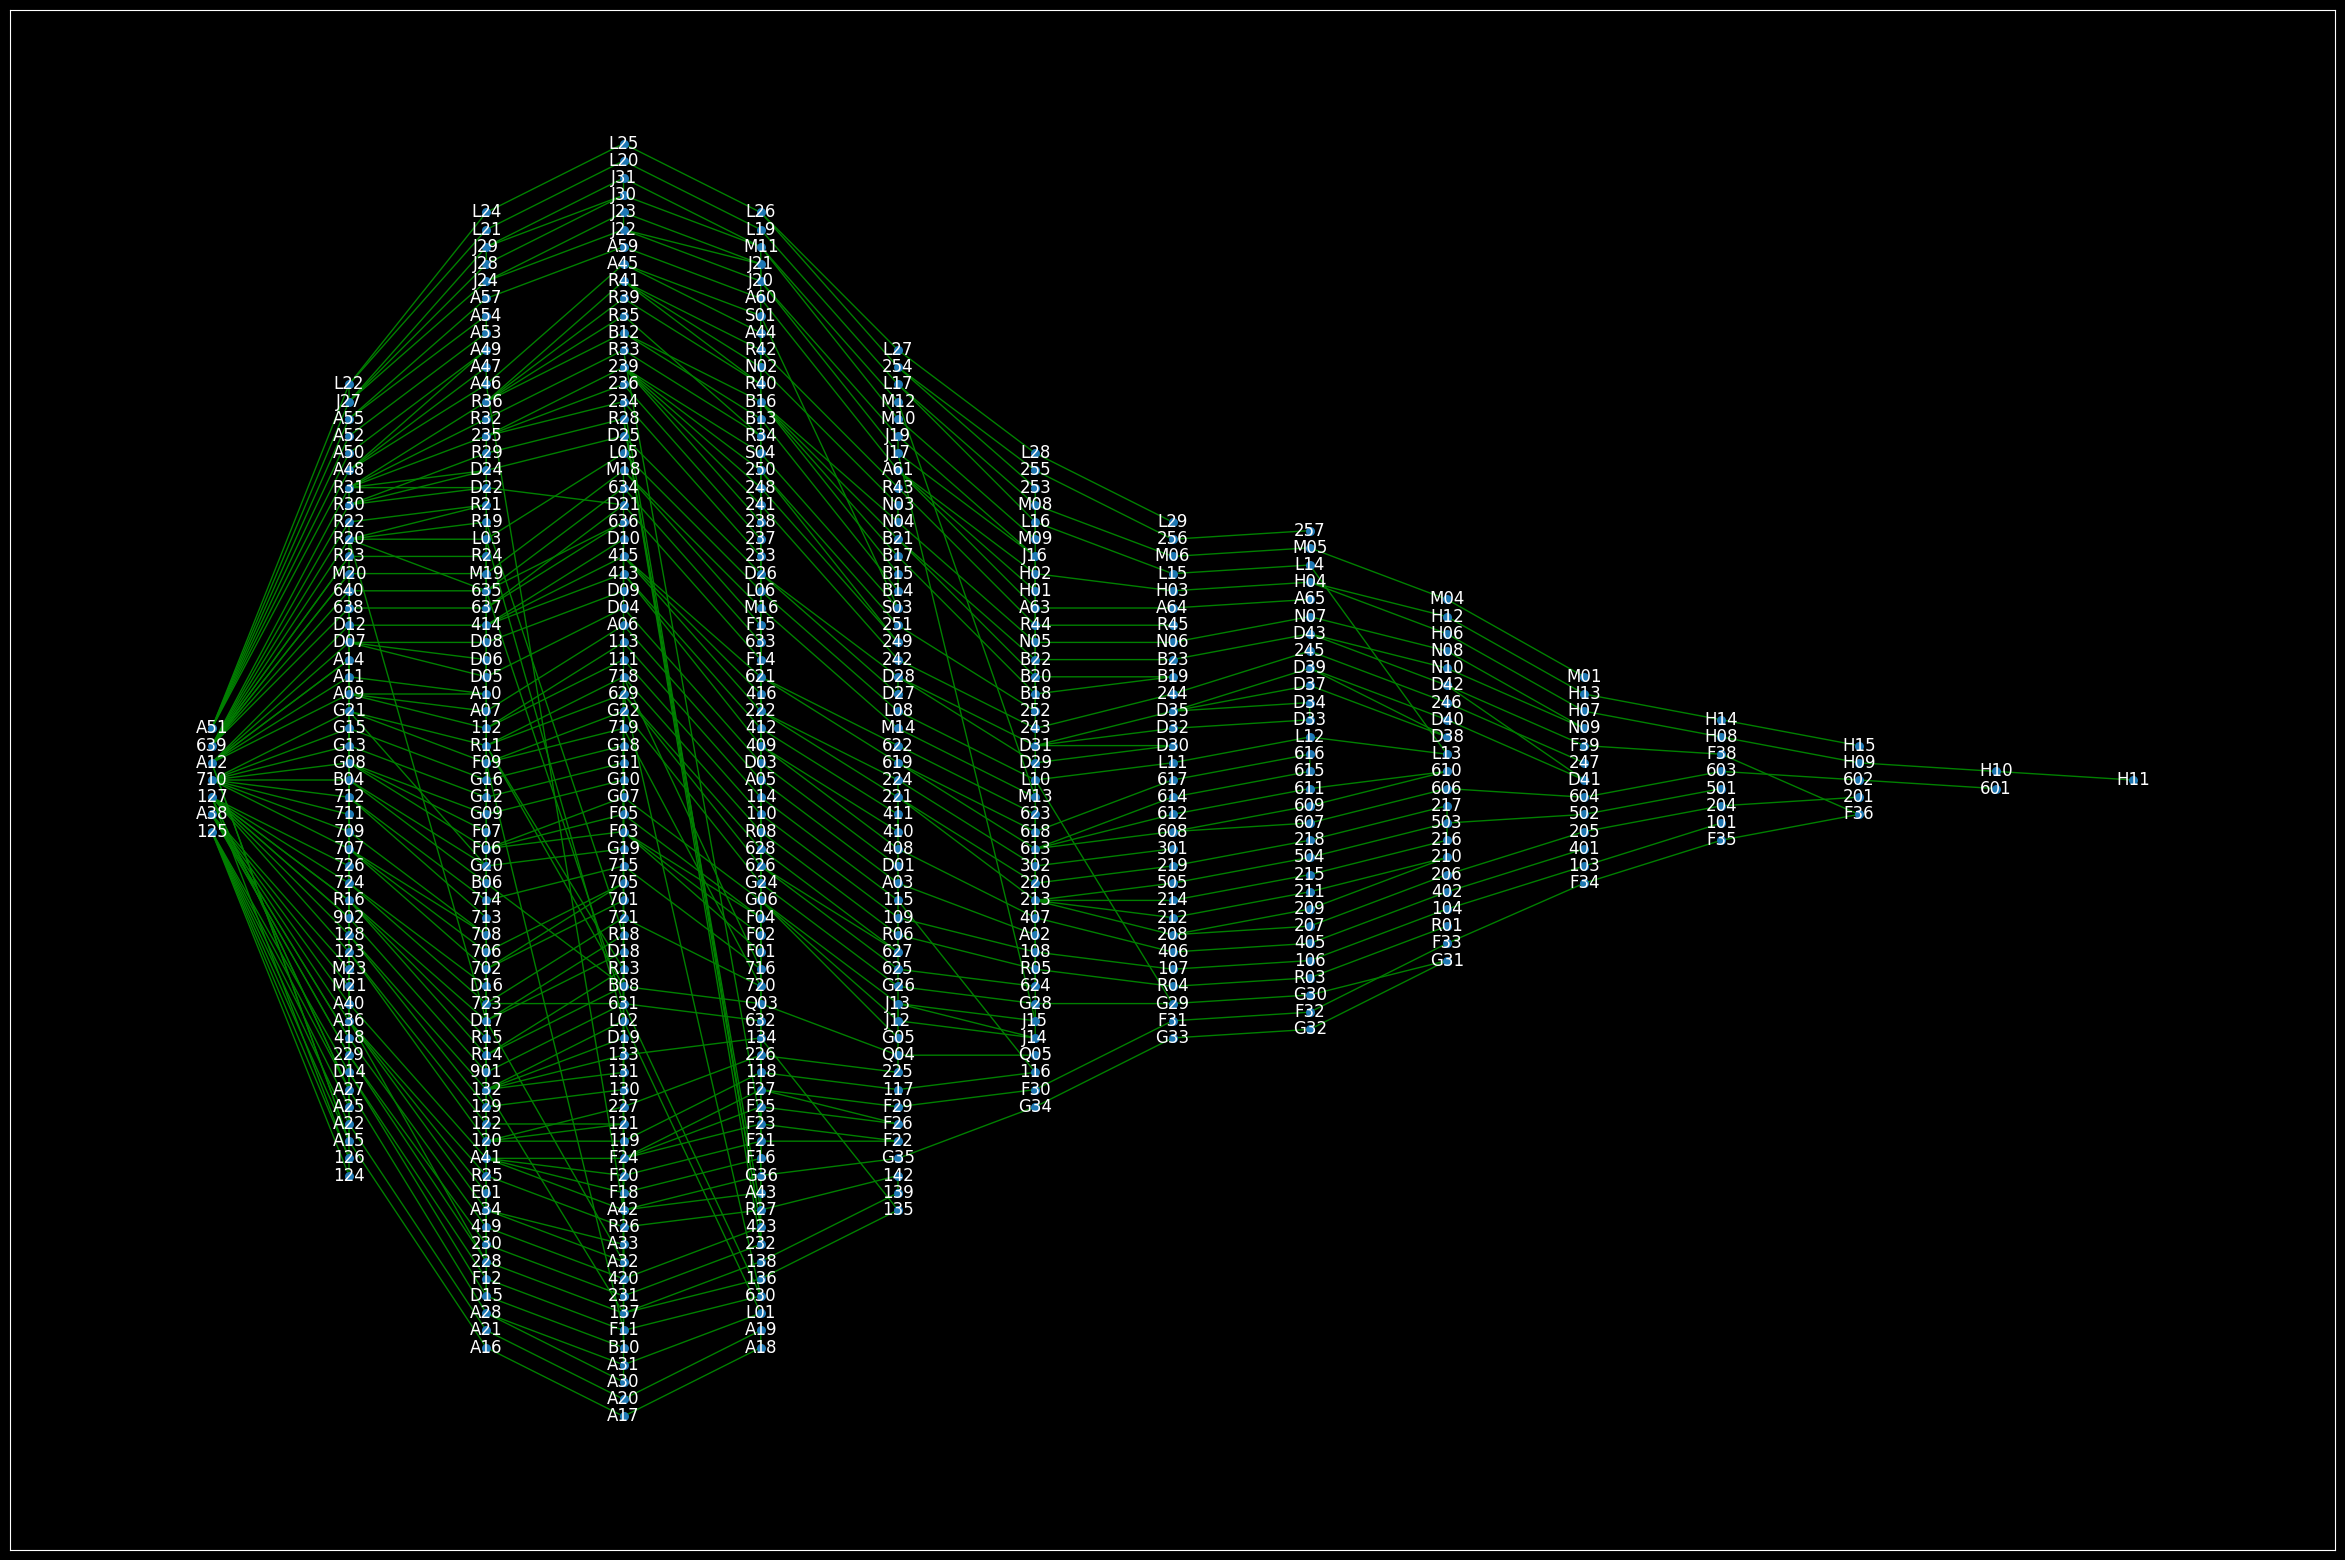

In [ ]:
plt.figure(2, figsize=(30,20))
pos2 = dict(enumerate(nx.bfs_layers(G_visual, ['127', '639','710','A12', 'A38', '125', 'A51'])))
pos2 = nx.multipartite_layout(G_visual, pos2)
nx.draw_networkx(G_visual, with_labels=True, node_size=30, edge_color='g', font_color='w', width=1, pos = pos2)